In [29]:
import zipfile
import os

# Define the path to the uploaded file
zip_file_path = '/content/archive.zip'
extracted_dir_path = '/mnt/data/extracted_files'

# Create a directory to extract the files
os.makedirs(extracted_dir_path, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# List the files extracted
extracted_files = os.listdir(extracted_dir_path)
extracted_files


['dataset_blood_group']

In [30]:
# List the contents of the extracted directory
dataset_dir_path = os.path.join(extracted_dir_path, 'dataset_blood_group')
dataset_files = os.listdir(dataset_dir_path)
dataset_files


['B-', 'A-', 'O-', 'AB-', 'A+', 'AB+', 'B+', 'O+']

In [31]:
# import packages
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing. image import ImageDataGenerator
from collections import Counter
import shutil
from sklearn.utils import resample
from tensorflow. keras. preprocessing. image import load_img, img_to_array, save_img
from tensorflow. keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
data_path='/mnt/data/extracted_files/dataset_blood_group'

In [33]:
Batch_size=32

In [34]:
#  Load dataset
dataset = image_dataset_from_directory(data_path,labels="inferred",
label_mode="int", image_size=(64, 64), batch_size=Batch_size, shuffle=True)

Found 6000 files belonging to 8 classes.


In [35]:
# Check class distribution in the dataset
class_names = dataset.class_names
class_counts = Counter ()
for _, labels in dataset.unbatch():
  class_counts[int (labels.numpy())] += 1
print("Class Distribution:")

for i, count in class_counts.items():
  print(f" {class_names [i]}: {count}")

Class Distribution:
 O-: 712
 B+: 652
 A-: 1009
 AB-: 761
 AB+: 708
 A+: 565
 B-: 741
 O+: 852


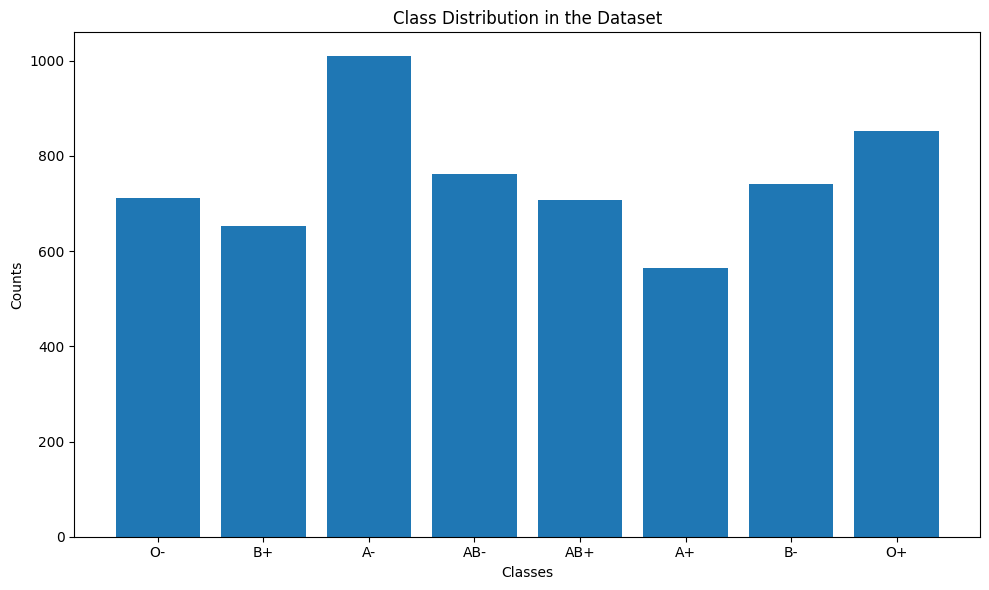

In [36]:
# def function to plot class distribution in the dataset
def plot_class_distribution_in_the_dataset(class_names,class_counts):
  """
    Plots the class distribution in the dataset.

    Parameters:
    class_names (dict): A dictionary where keys are class indices and values are class names.
    class_counts (dict): A dictionary where keys are class indices and values are the count of instances for each class.
    """
# Extract class names and their corresponding counts
classes = [class_names[i] for i in class_counts .keys()]
counts = [class_counts[i] for i in class_counts .keys()]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, counts)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Distribution in the Dataset')
plt.xticks()
plt.tight_layout()
plt.show()

In [37]:
max_count = max(class_counts.values())

In [38]:
def oversample_class(dataset, class_id, count,max_count):
    """
    Oversamples the specified target class in the dataset.

    Parameters:
    dataset (tf.data.Dataset): The original dataset.
    class_id (int): The ID of the class to oversample.
    count (int): The current count of the target class in the dataset.
    max_count (int): The desired maximum count for the target class.

    """
    # Unbatched  data for filtering
    unbatched_dataset = dataset.unbatch()

    # Filter the dataset
    class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))

    # Calculate the number of repetitions needed
    repeat = max_count // count + (max_count % count > 0)
 # Repeat the filtered dataset to reach the desired count and take the exact max_count samples


    return class_dataset.repeat(repeat).take(max_count)


In [39]:
balanced_datasets = []
for class_id, count in class_counts.items():
    # Include the dataset argument in the function call
    balanced_datasets.append(oversample_class(dataset, class_id, count, max_count))

In [40]:

balanced_dataset = tf.data.Dataset.sample_from_datasets (balanced_datasets)
# Check balanced class distribution
balanced_class_counts = Counter([int (lbl.numpy()) for _, lbl in balanced_dataset])
plot_class_distribution_in_the_dataset(class_names, balanced_class_counts)
#  Batch the balanced dataset
balanced_dataset = balanced_dataset.batch (Batch_size, drop_remainder=True)

In [41]:
for sample in balanced_dataset.take(5):
    print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [42]:

# dataset_size = number of elements in balanced_dataset_unbatched
# train_ratio = 0.7
# val_ratio = 0.2
# BATCH_SIZE = 32

# Calculate the dataset size
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)

# Compute sizes based on dataset size and desired splits
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

# Print sizes to debug
print(f"Total dataset size: {dataset_size}")
print(f"Training size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

# Split the dataset into training, validation, and test
balanced_dataset_unbatched = balanced_dataset.unbatch()  # re-unbatch since the previous unbatch operation consumed the dataset
train_dataset = balanced_dataset_unbatched.take(train_size)
val_test_dataset = balanced_dataset_unbatched.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Rebatch the datasets after splitting
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

# Check the number of batches in each dataset
train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")
print(f"Test dataset size: {test_batch_count * BATCH_SIZE}")


Total dataset size: 8064
Training size: 5644
Validation size: 1612
Test size: 808
Training dataset size: 5632
Validation dataset size: 1600
Test dataset size: 800


In [47]:
import tensorflow as tf

def CNN_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')  # Adjust the number of units for your specific problem
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create the model
model = CNN_model()
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,677,002 (14.03 MB)

 Trainable params: 3,677,002 (14.03 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Define ReduceLROnPlateau callback to reduce learning rate when validation loss plateaus
reduce_ir = ReduceLROnPlateau (monitor= 'val_loss',
 factor=0.5, patience=3, verbose=1, min_1r=1e-6 )

early_stop = EarlyStopping(
monitor= 'val_loss',
patience=5,
verbose=1)

In [49]:

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=30,
                    batch_size=100,
                    verbose=1,
                    callbacks=[reduce_ir, early_stop])

Epoch 1/30
    176/Unknown 106s 580ms/step - accuracy: 0.1180 - loss: 32.6992

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


176/176 ━━━━━━━━━━━━━━━━━━━━ 122s 669ms/step - accuracy: 0.1181 - loss: 32.5643 - val_accuracy: 0.1305 - val_loss: 2.1745 - learning_rate: 0.0010
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 116s 658ms/step - accuracy: 0.1661 - loss: 2.0547 - val_accuracy: 0.2586 - val_loss: 1.9644 - learning_rate: 0.0010
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 117s 662ms/step - accuracy: 0.3323 - loss: 1.7573 - val_accuracy: 0.4565 - val_loss: 1.6303 - learning_rate: 0.0010
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 118s 672ms/step - accuracy: 0.4706 - loss: 1.4512 - val_accuracy: 0.4688 - val_loss: 1.4880 - learning_rate: 0.0010
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 115s 652ms/step - accuracy: 0.5865 - loss: 1.1330 - val_accuracy: 0.4963 - val_loss: 1.4033 - learning_rate: 0.0010
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 128s 725ms/step - accuracy: 0.6446 - loss: 0.9742 - val_accuracy: 0.6415 - val_loss: 1.2549 - learning_rate: 0.0010
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 145s 741ms/step - accuracy: 0.6644

In [50]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [52]:
# Get predictions on the test dataset
y_actual =[] # Actual labels
y_pred =[] # Predicted labels

# Iterate over the test dataset and collect the true and predicted labels
for images, labels in test_dataset:
  predictions = model.predict (images)
# Convert one-hot encoded predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)
y_actual.extend (labels.numpy())
y_pred.extend (predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


In [58]:
# Get unique classes from y_actual and y_pred
unique_classes = np.unique(np.concatenate((y_actual, y_pred)))

# Check if all unique classes are in class_names
missing_classes = [c for c in unique_classes if c not in range(len(class_names))]

if missing_classes:
    print(f"Warning: Classes {missing_classes} are present in predictions but not in class_names.")

# Filter class_names to match unique classes
class_names_filtered = [class_names[i] for i in unique_classes]


# Classification report
report = classification_report(y_actual, y_pred, target_names=class_names_filtered)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

          A-       0.67      1.00      0.80         4
         AB+       1.00      1.00      1.00         3
         AB-       1.00      0.71      0.83        14
          B+       0.00      0.00      0.00         0
          B-       0.91      0.91      0.91        11
          O-       0.00      0.00      0.00         0

    accuracy                           0.84        32
   macro avg       0.60      0.60      0.59        32
weighted avg       0.93      0.84      0.87        32



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [60]:

# Get predictions on the test dataset
y_actual = []  # Actual labels
y_pred = []  # Predicted labels

# Iterate over the test dataset and collect the true and predicted labels
for images, labels in test_dataset:
    predictions = model.predict(images)
    # Convert one-hot encoded predictions to class labels
    predicted_labels = np.argmax(predictions, axis=1)
    y_actual.extend(labels.numpy())
    y_pred.extend(predicted_labels)

# Convert lists to numpy arrays
y_actual = np.array(y_actual)
y_pred = np.array(y_pred)

# Classification report
report = classification_report(y_actual, y_pred, target_names=class_names)
print("Classification Report:")
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Classification Report:
  

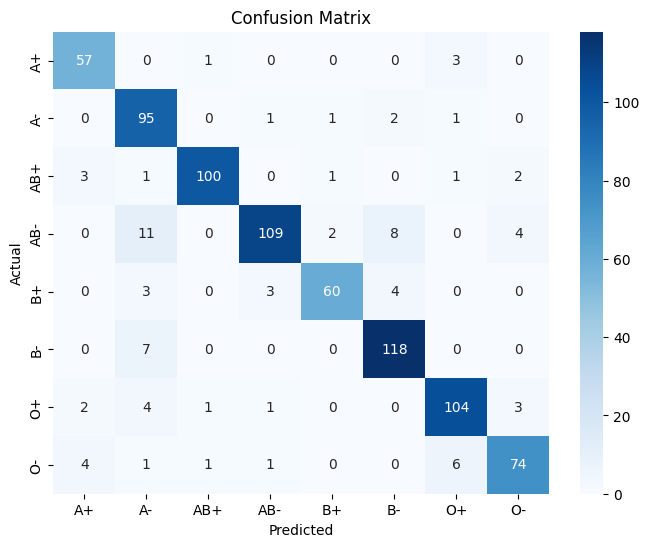

In [61]:
# Confusion matrix
conf_matrix = confusion_matrix(y_actual, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [62]:
# The model will be saved as 'my_model.h5'
model.save('model.h5')
print("Nodel saved as HDFS format.")

Nodel saved as HDFS format.
